In [1]:
import keras
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import pandas as pd
import pickle
import elf
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
baseline = 'PBE_dz'
reference = 'MB-pol'
# systems = ['dimers','trimers','128']
# systems = ['monomers','dimers','trimers','64']
# systems = ['monomers','dimers','trimers']
systems = ['64']
which = 'o'
all_targets = []
all_features = []
for system in systems:
    elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/elfs/basis_default_nn/{}_processed.hdf5'.format(system), which)

    angles = np.concatenate([[e.angles for e in e] for e in elfs], axis = 0)
    feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0 )

    if which == 'h':
        fro, to = 1,3
    else:
        fro, to = 0,1

    tar_baseline= np.genfromtxt('../data/' +baseline + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to] 
    tar_reference = np.genfromtxt('../data/' +reference + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to]
    targets = tar_reference - tar_baseline
    targets = np.concatenate(targets, axis = 0)
    targets_oriented = np.array(targets)
    for i,_ in enumerate(targets):
        targets_oriented[i] = elf.geom.rotate_vector(targets[i:i+1], angles[i], inverse=True) 
    targets = targets_oriented
    all_features.append(feat)
    all_targets.append(targets)
feat = np.concatenate(all_features)
targets = np.concatenate(all_targets)

{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}


OSError: ../data/MB-pol/64/forces.dat not found.

In [35]:
feat_mask = (np.ptp(feat, axis =0) > 1e-3)
feat = feat[:, feat_mask]

tar = targets
percentile_cutoff = 0.01
selection = []
for t in tar.T:
    lim1 = np.percentile(t, percentile_cutoff*100)
    lim2 = np.percentile(t, (1 - percentile_cutoff)*100)
    min_lim, max_lim = min(lim1,lim2), max(lim1,lim2)
    selection.append((t > min_lim) & (t < max_lim))

filt = [s1 & s2 & s3 for s1,s2,s3 in zip(*selection)]


feat = feat[filt]
tar = tar[filt]
print(feat.shape)

# scaler = Normalizer()
# scaler.fit(feat)
# feat = scaler.transform(feat)

# pca = PCA(n_components=36)
# feat = pca.fit_transform(feat)

scaler = MinMaxScaler()
scaler.fit(feat)
feat = scaler.transform(feat)
#     feat = mono_feat
#     tar = mono_targets
#     feat = np.concatenate([mono_feat,dimer_feat], axis = 0)
#     tar = np.concatenate([mono_targets,dimer_targets], axis = 0)
# X_train, X_test, y_train, y_test = train_test_split(feat, 
#                                                     tar,
#                                                     shuffle =True, random_state = 42, test_size = 0.4) 


(8735, 16)


In [36]:
filt_o = np.array(filt)

In [37]:
filt_h = np.array(filt)

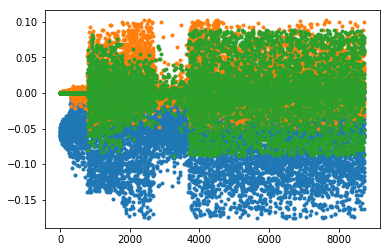

In [38]:
plot(tar, ls ='', marker = '.')

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

X_train, X_test, y_train, y_test = train_test_split(feat, 
                                                    tar, 
                                                    shuffle =True, random_state = 42, test_size = 0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                    y_train, 
                                                    shuffle =True, random_state = 42, test_size = 0.2)



b = 0
model = Sequential()
s = 8
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b), input_dim=X_train.shape[1]))
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b)))
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b)))
model.add(Dense(units=3, activation='linear'))
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['accuracy'])



In [40]:
last_train = 1000
last_valid = 1000

for i in range(100):
    model.fit(X_train, y_train, epochs=500, batch_size= 500, verbose=0)
    train_loss = np.sqrt(model.evaluate(X_train, y_train, verbose = 0)[0])
    valid_loss = np.sqrt(model.evaluate(X_valid, y_valid, verbose = 0)[0])
    if train_loss < last_train and valid_loss > last_valid:
        break  #Early stopping
    else:
        last_train = train_loss
        last_valid = valid_loss
    print(train_loss, valid_loss)

0.022436815213856497 0.022757279508156755
0.02119134903053495 0.021302033521110268
0.021731781055471085 0.02168654291315331
0.022774827410152916 0.02276884690614324
0.018802307120465635 0.019029364492109863
0.01870360156181216 0.019024844200272915
0.018018360494605215 0.01862184587820655
0.017587408582829096 0.018226426339137555
0.0168257499655474 0.017439626588019896
0.01680392002288145 0.017333135253736667
0.01693528365522078 0.017590536828213276
0.016755158953728127 0.017541841914758296
0.016166358581330788 0.016948885708105366
0.01559560794124032 0.016428628830135947
0.015799157388854866 0.016692835178600027
0.015517725539295504 0.016352848205932403


KeyboardInterrupt: 

In [41]:
rmd, _ = model.evaluate(X_test, y_test)
np.sqrt(rmd)

1747/1747 [==============================] - 0s 27us/step


0.016892040455291524

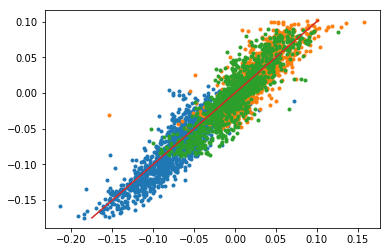

In [42]:
plot(model.predict(X_test), y_test, ls = '', marker = '.')
min_ = np.min(y_test)
max_ = np.max(y_test)
plot([min_, max_],[min_,max_])

In [43]:
model_name = 'revpbe_to_pbe_v2'

In [44]:
model.save('../../elf_models/models_1e-5/{}/force_{}'.format(model_name, which.upper()))

In [45]:
with open('../../elf_models/models_1e-5/{}/scaler_{}'.format(model_name, which.upper()), 'wb') as file:
    pickle.dump(scaler, file)

In [46]:
# baseline = 'PBE_sz'
# reference = 'PBE_dz'

# which = 'h'
systems = ['64']
all_targets = []
all_features = []
model = keras.models.load_model('../../elf_models/models_1e-5/{}/force_{}'.format(model_name, which.upper()))
scaler = pickle.load(open('../../elf_models/models_1e-5/{}/scaler_{}'.format(model_name, which.upper()), 'rb'))
for system in systems:
    elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/elfs/basis_default_elf/{}_processed.hdf5'.format(system), which)

    angles = np.concatenate([[e.angles for e in e] for e in elfs], axis = 0)
    feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0 )

    if which == 'h':
        fro, to = 1,3
    else:
        fro, to = 0,1

    tar_baseline= np.genfromtxt('../data/' + baseline + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to] 
    tar_reference = np.genfromtxt('../data/' + reference + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to]
    targets = tar_reference - tar_baseline
    targets = np.concatenate(targets, axis = 0)
    targets_oriented = np.array(targets)
    for i,_ in enumerate(targets):
        targets_oriented[i] = elf.geom.rotate_vector(targets[i:i+1], angles[i], inverse=True) 
    targets = targets_oriented
    all_features.append(feat)
    all_targets.append(targets)
feat = np.concatenate(all_features)
targets = np.concatenate(all_targets)
feat = feat[:,feat_mask]
feat = scaler.transform(feat)

{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}


0.027722723557490905


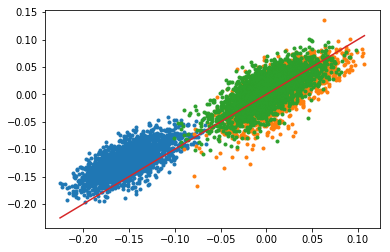

In [33]:
plot(targets, model.predict(feat),ls ='', marker = '.')
plot([np.min(targets), np.max(targets)],[np.min(targets),np.max(targets)])
print(np.sqrt(np.mean((targets -model.predict(feat))**2)))